In [1]:
train.data <- read.csv(file.path("..", "data", "training_data.csv"))
test.data <- read.csv(file.path("..", "data", "test_data.csv"))

In [2]:
#set seed for reproduction
set.seed(1)

#searching for input variables with zero variance (without the varible Intensity)
x <- train.data[, -c(1,2,3)]
idx.zero.var <- apply(x, 2, var) == 0
x <- x[,!idx.zero.var]

#attache Intensity as factor
x$Intensity <- as.factor(train.data$Intensity)

data <- x
data$VALENCE.PLEASANTNESS <- train.data$VALENCE.PLEASANTNESS

## Parameter selection with 5-fold Cross-Validation 

In [60]:
library(randomForest)
library(tidymodels)

#Function for Cross-Validation and Predictions
fit_and_evaluate <- function(fold, formula = VALENCE.PLEASANTNESS ~ ., mtry = 55, ntree = 100, maxnodes = 30) {
    random.Forest <- randomForest::randomForest(VALENCE.PLEASANTNESS ~ ., fold, mtry = mtry, ntree = ntree, maxnodes = maxnodes)
    valid.set <- assessment(fold)
    mean((valid.set$VALENCE.PLEASANTNESS - predict(random.Forest, valid.set))^2)
}

#Cross-Validation set
validation_data <- vfold_cv(data, v = 5)  

cv.errors_mtry <- c()
cv.errors_ntree <- c()
cv.errors_maxnodes <- c()



In [61]:
#Iteration of mtry (mtry around sqrt(number of predictors))
for (i in 40:80){   
    cv.errors_mtry <- rbind(cv.errors_mtry, sapply(validation_data$splits, fit_and_evaluate, mtry = i))
}

Saving 6.67 x 6.67 in image



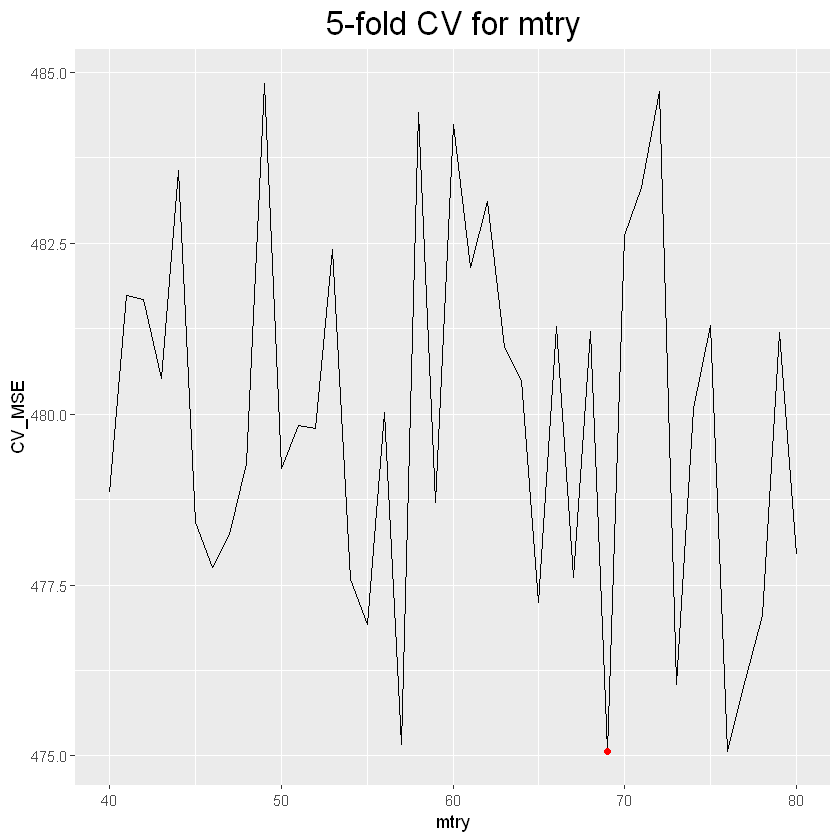

In [62]:
mean.cv.errors_mtry <- rowMeans(cv.errors_mtry)
cv.min_mtry = which.min(mean.cv.errors_mtry)

theme_update(plot.title = element_text(hjust = 0.5, size = 20))

mtry.data <- data.frame("mtry" = 40:80, "CV_MSE" = mean.cv.errors_mtry)
mtry.data %>% ggplot(aes(x = mtry, y = CV_MSE)) + geom_line() + ggtitle("5-fold CV for mtry") + 
geom_point(aes(cv.min_mtry+39, mean.cv.errors_mtry[cv.min_mtry]), col = "red")

ggsave("../Pictures/mtry.png")

In [63]:
#Iteration of ntree
for (i in 2:500){   
    cv.errors_ntree <- rbind(cv.errors_ntree, sapply(validation_data$splits, fit_and_evaluate, mtry = cv.min_mtry+39, ntree = i))
}

Saving 6.67 x 6.67 in image



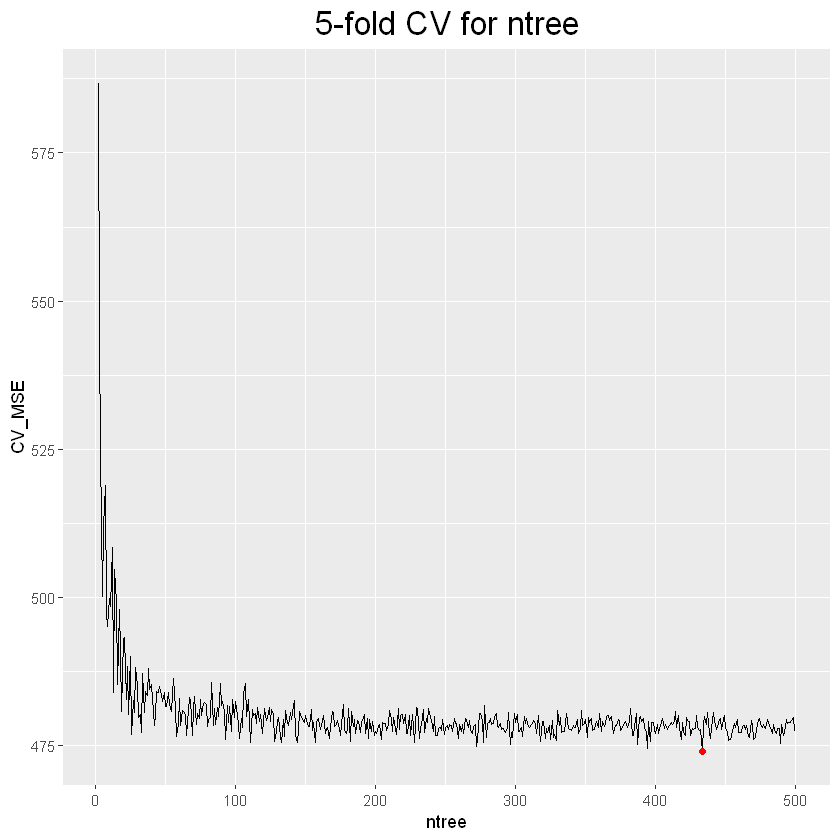

In [64]:
mean.cv.errors_ntree <- rowMeans(cv.errors_ntree)
cv.min_ntree = which.min(mean.cv.errors_ntree)

ntree.data <- data.frame("ntree" = 2:500, "CV_MSE" = mean.cv.errors_ntree)
ntree.data %>% ggplot(aes(x = ntree, y = CV_MSE)) + geom_line() + ggtitle("5-fold CV for ntree") + 
geom_point(aes(cv.min_ntree+1, mean.cv.errors_ntree[cv.min_ntree]), col = "red")

ggsave("../Pictures/ntree.png")

In [65]:
#Iteration of maxnodes
for (i in 5:50){   
    cv.errors_maxnodes <- rbind(cv.errors_maxnodes, sapply(validation_data$splits, fit_and_evaluate, mtry = cv.min_mtry+39, ntree = cv.min_ntree+1, maxnodes = i))
}

Saving 6.67 x 6.67 in image



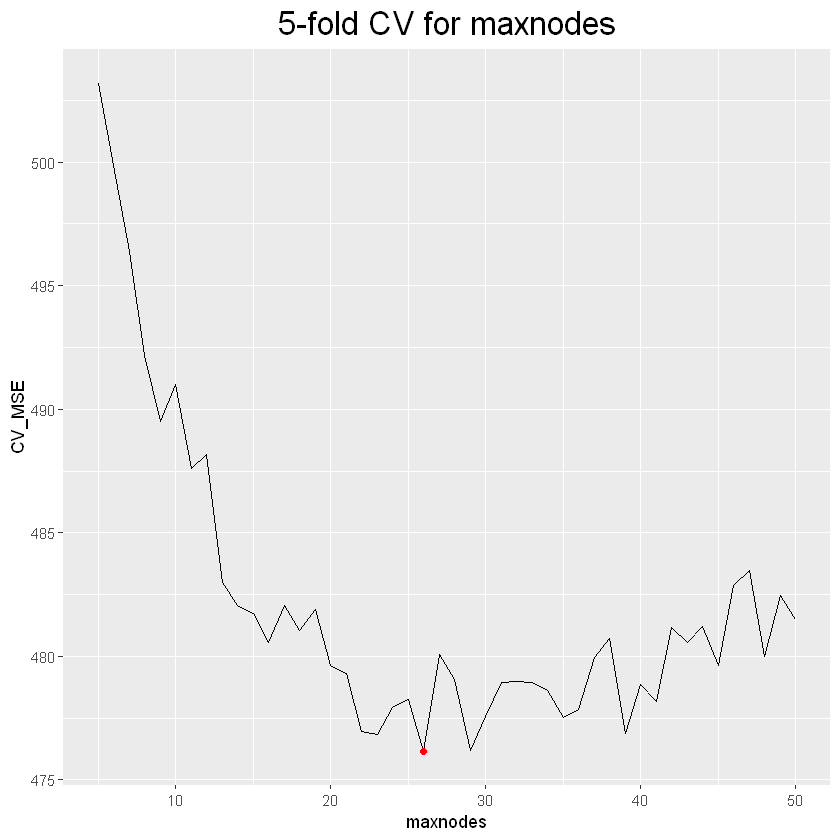

In [66]:
mean.cv.errors_maxnodes <- rowMeans(cv.errors_maxnodes)
cv.min_maxnodes = which.min(mean.cv.errors_maxnodes)

maxnodes.data <- data.frame("maxnodes" = 5:50, "CV_MSE" = mean.cv.errors_maxnodes)
maxnodes.data %>% ggplot(aes(x = maxnodes, y = CV_MSE)) + geom_line() + ggtitle("5-fold CV for maxnodes") + 
geom_point(aes(cv.min_maxnodes+4, mean.cv.errors_maxnodes[cv.min_maxnodes]), col = "red")

ggsave("../Pictures/maxnodes.png")

In [67]:
cat("The optimal parameters are: mtry = ", cv.min_mtry+39, " ntree = ", cv.min_ntree+1, " and maxnodes = ", cv.min_maxnodes+4)

The optimal parameters are: mtry =  69  ntree =  433  and maxnodes =  26

## Validation of best Model

In [25]:
library(randomForest)
library(tidymodels)

random.forest.validation <- function(seed){
    set.seed(seed)
    len <- length(data[,1])
    idx.train <- sample(1:len, 2*len/3)
    train <- data[idx.train, ]
    validation <- data[-idx.train, ]
    
    r.Forest <- randomForest::randomForest(VALENCE.PLEASANTNESS ~ ., train, mtry = 69, ntree = 433, maxnodes = 26)
    prediction <- predict(r.Forest, validation)
    mean((prediction - validation$VALENCE.PLEASANTNESS)^2)
    
}
seeds <- seq.int(100,150)
MSEs <- sapply(seeds, random.forest.validation)
mean.MSE <- mean(sqrt(MSEs))
var <- var(sqrt(MSEs))
cat("The mean RMSE is = ", mean.MSE, " and the variance is = ", var)

The mean RMSE is =  21.77088  and the variance is =  0.7258364

In [24]:
sqrt(mean.MSE)
var(sqrt(MSEs))

[1] 21.78721

[1] 0.7258364

## Submission

In [ ]:
#Random Forest Submission
set.seed(1)
#Preparation of training and test data
train <- train.data[, -c(1,2,3)]
idx.zero.var <- apply(train, 2, var) == 0

train <- train[,!idx.zero.var]
test <- test.data[,-c(1,2)]
test <- test[,!idx.zero.var]

test$Intensity <- as.factor(test.data$Intensity)
train$Intensity <- as.factor(train.data$Intensity)


#test intensity is always at level high, so that the prediction function has a problem (cheat with adding a row that afterwards is substracted)
test <- rbind(test, train[1,])


train$VALENCE.PLEASANTNESS <- train.data$VALENCE.PLEASANTNESS

r.Forest <- randomForest::randomForest(VALENCE.PLEASANTNESS ~ ., train, mtry = 69, ntree = 433, maxnodes = 26)
random.Forest.prediction <- predict(r.Forest, test)

#substracting added row
len <- length(random.Forest.prediction)
random.Forest.prediction <- random.Forest.prediction[-len]


In [29]:
#Creation of csv submission-file
submission <- data.frame(Id = 1:68, VALENCE.PLEASANTNESS = random.Forest.prediction)
write.csv(submission, file = "../Submissions/random_forest.csv", row.names = FALSE)